# *Fake News Study* / Etude Fake News

*EN* // **FR**

*Data files are stored in 'Data' repertory, the whole purpose of this work is to
develop an AI that recognizes Fake News, train it and test it to bring it to the highest
accuracy possible.*

**Les données sont stockées dans le dossier 'Data', le but de ce travail est de développer une IA capable de reconnaître
les fake news, l'entraîner, la tester et l'amener à la plus haute précision possible.**

## Imports

In [1]:
# Utils libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pyarrow.feather as ft

# AI libs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score

## *Creating a dataset to work with* / Création du dataset de travail

In [2]:
fake = pd.read_csv('../Data/Fake.csv', delimiter=',')
true = pd.read_csv('../Data/True.csv', delimiter=',')

*We now need to merge these two dataframes to be able to use them as one whole entity.
Nevertheless, we will need to differentiate real and fake news, so we will have to add
an extra column as 'istrue'.*

**Nous devons maintenant concaténer ces deux DataFrames pour pouvoir les utiliser en tant qu'une seule et même entité.
Cependant, nous devons être capable de différencier les news fakes et réelles, nous allons donc rajouter une colonne
de booléens 'istrue'.**

In [3]:
fake['istrue'] = 0
true['istrue'] = 1

data = true.append(fake)

*We now have a full dataframe with real and fake news, let's check the dimensions
and fields we have.*

**Nous avons maintenant un DataFrame complet avec les news réelles et fakes, vérifions dimensions et champs.**

In [4]:
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,istrue
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## *Analyzing, cleaning and repairing data* / Analyse, nettoyage et réparation des données

*Now that we have the dataset we needed, let's look for null or NaN values in it.*

**Maintenant que nous avons le bon dataset, regardons s'il contient des valeurs NULL ou NaN.**

In [5]:
print(data.isnull().sum())

title      0
text       0
subject    0
date       0
istrue     0
dtype: int64


*We can see from this execution that there is no null or NaN value in the dataset, so
we won't have to repair any of the data, which is good news.
<br>
We will now delete the column we won't need during the study : date.*

**Nous nous rendons compte suite à cette exécution qu'aucune valeur NULL ou NaN ne se trouve dans le dataset, nous n'aurons donc pas à réparer les données, ce qui est une bonne nouvelle.
<br>
Nous allons maintenant supprimer la colonne dont nous n'aurons pas besoin dans cette étude : date**

In [6]:
data = data.drop(columns='date')
data.head()

,title,text,subject,istrue
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


*However, we will need to split title contents into more simplified strings to avoid confusion
during data processing.
<br>
To this purpose, we'll use the nltk and re libraries, which contain
stopwords and string processing packages (called PortStemmer).
But first, let's make an array that contains all titles.*

**Cependant, nous allons avoir besoin de séparer les contenus des titres en des chaînes de caractères plus simplifiées pour éviter les confusions durant l'exploitation des données.
<br>
Pour cela, nous aurons besoin des bibliothèques nltk et re, qui contiennent des packages liés aux mots de liaison et aux traitements de chaînes de caractères (notamment le PortStemmer)**

***Stopwords:***
<br>
*A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search
engine has been programmed to ignore, both when indexing entries for searching
and when retrieving them as the result of a search query.
(https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)*
<br>
**Un mot de liaison est un mot couramment utilisé (comme "et", "ou", "un", etc) qu'un moteur de recherche a été programmé pour ignorer, que ce soit lors de l'indexation des entrées pour la recherche
ou lors de leur récupération en tant que résultat d'une requête de recherche.
(https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**

***PortStemmer:***
<br>
*A PortStemmer is an algorithm used for removing the commoner morphological and
inflexional endings from words in English. For example: words such as “Likes”,
”liked”, ”likely” and ”liking” will be reduced to “like” after stemming.
(https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)*
<br>
**Un PortStemmer est un algorithme utilisé pour supprimer les terminaisons morphologiques et inflexionnelles les plus courantes des mots.
Par exemple, des mots tels que "Likes", "liked", "likely" et "liking" seront réduits à "like" après le stemming.
(https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)**

In [7]:
titles = np.array(data['title'])

nltk.download('stopwords')

corpustitle = []

for i in range (titles.shape[0]):
    new = re.sub('[^a-zA-Z]', ' ', titles[i])
    # Replaces any string matching the regex with spaces (anything other than a letter)

    new = new.lower()

    new = new.split()

    ps = PorterStemmer()
    new = [ps.stem(word) for word in new if not word in set(stopwords.words('english'))]

    new = ' '.join(new)

    corpustitle.append(new)

data['title'] = corpustitle
data.head()

[nltk_data] Downloading package stopwords to /Users/adute/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,subject,istrue
0,u budget fight loom republican flip fiscal script,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,u militari accept transgend recruit monday pen...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,senior u republican senat let mr mueller job,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,fbi russia probe help australian diplomat tip nyt,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,trump want postal servic charg much amazon shi...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


In [40]:
text = np.array(data['text'])

corpustxt = []

for i in range (text.shape[0]):
    new = re.sub('[^a-zA-Z]', ' ', text[i])
    # Replaces any string matching the regex with spaces (anything other than a letter)

    new = new.lower()

    new = new.split()

    ps = PorterStemmer()
    new = [ps.stem(word) for word in new if not word in set(stopwords.words('english'))]

    new = ' '.join(new)

    corpustxt.append(new)

data['text'] = corpustxt
data.head()

,title,text,subject,istrue
0,u budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...,politicsNews,1
1,u militari accept transgend recruit monday pen...,washington reuter transgend peopl allow first ...,politicsNews,1
2,senior u republican senat let mr mueller job,washington reuter special counsel investig lin...,politicsNews,1
3,fbi russia probe help australian diplomat tip nyt,washington reuter trump campaign advis georg p...,politicsNews,1
4,trump want postal servic charg much amazon shi...,seattl washington reuter presid donald trump c...,politicsNews,1


In [41]:
feather = data.reset_index()
ft.write_feather(data, '../Data/datas.feather', compression='zstd')

*Now that our titles are simplified, let's vectorize them using CountVectorizer
(provided by sklearn)*
<br>
**Maintenant que nos titres sont simplifiés, vectorisons-les en utilisant CountVectorizer
(fourni par sklearn)**

***CountVectorizer:***
<br>
*CountVectorizer is a tool provided by the scikit-learn library. It is used to transform
a given text into a vector on the basis of the frequency (count) of each word that occurs
in the entire text.
(https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/)*
<br>
**CountVectorizer est un outil fourni par la bibliothèque scikit-learn. Il est utilisé pour transformer
un texte donné en un vecteur sur la base de la fréquence (comptage) de chaque mot qui apparaît
dans le texte entier.
(https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/)**

In [2]:
countv = CountVectorizer(max_features=5000)
data = pd.read_feather('../Data/datas.feather')
# max_features: we are selecting the 5000 most used words in the whole dataset

X1 = countv.fit_transform(data['title']).toarray()
# Results are being encoded by the 'transform' part of the method

In [3]:
countv = CountVectorizer(max_features=5000)

# max_features: we are selecting the 5000 most used words in the whole dataset

X2 = countv.fit_transform(data['text']).toarray()
# Results are being encoded by the 'transform' part of the method

In [4]:
countv = CountVectorizer(max_features=5000)

# max_features: we are selecting the 5000 most used words in the whole dataset

X3 = countv.fit_transform(data['subject']).toarray()
# Results are being encoded by the 'transform' part of the method

0.9974387527839643 85


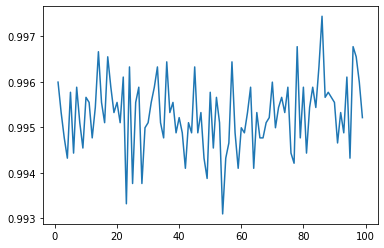

In [9]:
from sklearn.linear_model import LogisticRegression

def print_accuracy(accu_r, acc) :
    plt.plot(accu_r, acc)
    max_accu = max(acc)
    print(max_accu, acc.index(max_accu))

X = X2
Y = data['istrue'].values

accu_range = range(1, 100)
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    regr = LogisticRegression(random_state=val)
    classifier = regr.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)

0.9975501113585746 95


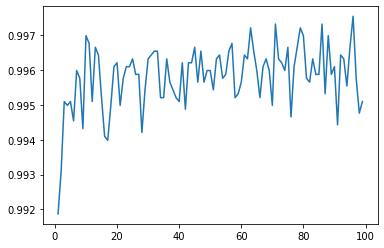

In [7]:
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    tree = DecisionTreeClassifier(max_depth=val, random_state=val*10)
    classifier = tree.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)

0.8657015590200445 0


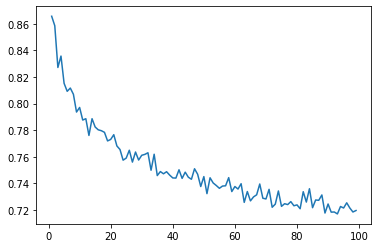

In [8]:
accu = []
for val in accu_range :
    x_svm_train, x_svm_test, y_svm_train, y_svm_test = train_test_split(X, Y, test_size=0.2, random_state=val)
    knn = KNeighborsClassifier(n_neighbors=val)
    classifier = knn.fit(x_svm_train, y_svm_train)
    y_prediction = classifier.predict(x_svm_test)
    accu.append(accuracy_score(y_svm_test, y_prediction))

print_accuracy(accu_range, accu)